# Build and Train Decision Trees for Classification Problems
## Purpose
In this example we will demonstrate how to:
   - Build a coreset tree for classification decision trees based on a real-world MultiClass dataset.
   - Perform coreset tree vs. entire train dataset vs. random selection comparison as follows:
      - Retrieve the coreset from the coreset tree using get_coreset, and train on Catboost's CatBoostClassifier model on it.
      - Build a CatBoostClassifier model on the entire train dataset.
      - Build a CatBoostClassifier model on a randomly-sampled train dataset, where the sample size exactly matches coreset size.
      - Build a CatBoostClassifier model on a randomly-sampled train dataset, where the sample size is large-enough to strive to match the quality of using the coreset from the coreset tree.
      - Compare the quality of all four models built.
   - Repeat the comparison sets above, using two additional flavours:
      - Utilizing Catboost's Pool object (instead of the CatBoostClassifier sklearn wrapper).
      - Calling our library's service object's direct fit function (employing CatBoostClassifier behind the scenes).
   - Employ coreset tree's utility functions for saving, loading and plotting the coreset tree.

For the example dataset, we will be using the PokerHand OpenML dataset (https://www.openml.org/search?type=data&status=active&id=155).
The data will be split into 'train' and 'test' portions using sklearn's train/test split (80% for the train portion, 20% for the test).
The 'train' portion will consist of roughly 663K samples, and the 'test' portion will have around 166K samples.
Our comparisons will utilize the balanced accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) as the evaluation metric.


In [1]:
import os
import warnings
from time import time

import numpy as np
import pandas as pd
import catboost as cb
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier 

from dataheroes import CoresetTreeServiceDTC

warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', DeprecationWarning)

## 1. Prepare the dataset & the testing environment

In [2]:
# Load PokerHand dataset as X, y (data, target) from openml.
X, y = fetch_openml("pokerhand", return_X_y=True)

# Label-Encode the target. We do so because, further down the road, we will use Catboost for
# modeling, which requires consecutive integer labels starting from 0.
label_enc = LabelEncoder()
y = label_enc.fit_transform(y)

# Merge 3 class labels into a single label, to make the data-set have only 5 targets.
# (Otherwise, the smaller class is made up of only 2 samples, and the last but one - with only 11.)
y[y > 3] = 4

# Split to train and test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Get categorical features indices from training data.
cat_features = X_train.select_dtypes(include=['category', 'object']).columns
cat_features_indices = [X_train.columns.get_loc(cat) for cat in cat_features]

#Convert the data to ndarray.
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Remember the number of classes (5) required for the upcoming training code.
num_classes = len(np.unique(y_train))
print(f"#classes={num_classes}, train size={len(X_train):,}, test size={len(X_test):,}")

# Define the number of estimators for Catboost.
# Even if we use the defaults, while 100 is the default for CatBoostClassifier, we do emphasize this value
# in a separate variable, for the sake of the comparison.
# The higher the number of estimators, the better the results will be (but the longer the time will take).
n_estimators = 100

# Set the tree access level which we will be working with (default is 0=root node).
tree_query_level = 3

# Remember the number of samples for the full dataset.
n_samples_full = len(y_train)

# Define the number of samples for the comparison flavour in which a randomly-selected dataset is striving to resemble coreset dataset's quality.
n_samples_rand_large = int(n_samples_full * 0.3)

# Define method for summarizing every flavour's experimental results in one neat table.
def produce_results(experiment_group : str,
                    n_samp_full : int, n_samp_rand_large : int, n_samp_coreset : int,
                    full_score : float, rand_large_score : float, rand_csize_score : float, coreset_score : float,
                    full_secs : float, rand_large_secs : float, rand_csize_secs : float, coreset_secs : float):

    df = pd.DataFrame(data={
        ' ': ['Full dataset', 'Random bigger-sized sample', 'Random smaller-sized sample', 'Coreset'],
        'Training dataset size': [n_samp_full, n_samp_rand_large, n_samp_coreset, n_samp_coreset],
        '% of full dataset': [n_samp_full / n_samp_full, n_samp_rand_large / n_samp_full, n_samp_coreset / n_samp_full, n_samp_coreset / n_samp_full],
        'Balanced accuracy score': [full_score, rand_large_score, rand_csize_score, coreset_score],
        'Training time (sec)': [full_secs, rand_large_secs, rand_csize_secs, coreset_secs],
    })
    last_row = pd.IndexSlice[df.index[-1], :]
    styles = [dict(selector="caption", props=[("text-align", "center"), ("font-size", "120%"), ("font-weight", "bold")])]
    s  = df.style \
        .set_properties(subset=[' '],**{'text-align':'left'}) \
        .set_properties(subset=['Training dataset size','% of full dataset','Balanced accuracy score','Training time (sec)'],**{'text-align':'right'}) \
        .set_properties(subset=last_row, **{'color':'green', 'font-weight':'bold'}) \
        .set_caption(f"{experiment_group} Results") \
        .format({
        'Training dataset size': '{:,}',
        '% of full dataset': '{:.2%}',
        'Balanced accuracy score': '{:.4f}',
        'Training time (sec)': '{:.2f}'}) \
        .hide(axis='index') \
        .set_table_styles(styles)
    return s

#classes=5, train size=663,360, test size=165,841


## 2. Build the coreset tree
Create a new service object and run `build` directly on the X, y train data.
We pass `chunk_size` and `coreset_size` instead of passing `n_instances` to initialize the coreset tree.

In [3]:
t = time()
# Define all columns as categorical, so they would be one-hot encoded by the dataheroes library.
data_params = {
    'categorical_features': cat_features,
    'ohe_min_frequency': 0
}
service_obj = CoresetTreeServiceDTC(optimized_for='training',
                                    chunk_size=40_000,
                                    coreset_size=12_000,
                                    data_params=data_params,
                                    model_cls=CatBoostClassifier,
                                   )
service_obj.build(X_train, y_train,copy=True)
coreset_build_secs = time() - t
print(f"Coreset build time (sec): {coreset_build_secs:.2f}")

Coreset build time (sec): 8.86


## 3. Tree-based coreset performance comparison: Catboost (sklearn Catboost wrapper) modeling approach

### 3.1 Get a coreset from the tree & train a model based on it

In [4]:
t = time()
# Get the coreset from the tree.
coreset = service_obj.get_coreset(level=tree_query_level)
indices_coreset_, X_coreset, y_coreset = coreset['data']
w_coreset = coreset['w']
X_coreset = pd.DataFrame(X_coreset)
cboost_classifier_coreset_model = CatBoostClassifier(objective='MultiClass',
                                                classes_count=num_classes,
                                                cat_features=cat_features_indices,
                                                verbose=False,
                                                n_estimators=n_estimators)

cboost_classifier_coreset_model.fit(X_coreset, y_coreset, sample_weight=w_coreset)
n_samples_coreset = len(y_coreset)
cboost_classifier_coreset_secs = time() - t

### 3.2. Train a model on the entire dataset (for comparison)
We use the same (entire) training part of the dataset that was used for building the coreset tree.

In [5]:
# mark all features as categorical
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [6]:
t = time()
# Train an Catboost model on the entire data-set.
cboost_classifier_full_model = CatBoostClassifier(objective='MultiClass',
                                                classes_count=num_classes,
                                                cat_features=cat_features_indices,
                                                verbose=False,
                                                n_estimators=n_estimators)
cboost_classifier_full_model.fit(X_train, y_train)
cboost_classifier_full_secs = time() - t

### 3.3. Train models on samples selected randomly from the training set

### 3.3.1. Produce a randomly-selected sample matching the coreset's size

In [7]:
t = time()
# Train an Catboost model on the random data-set -
# (1) Create the model, (2) randomly sample the exact size as the coreset size, and (3) train the model.
cboost_classifier_rand_csize_model = CatBoostClassifier(objective='MultiClass',
                                                classes_count=num_classes,
                                                cat_features=cat_features_indices,
                                                verbose=False,
                                                n_estimators=n_estimators)
cboost_classifier_rand_csize_idxs = np.random.choice(n_samples_full, n_samples_coreset, replace=False)
cboost_classifier_rand_csize_model.fit(X_train.iloc[cboost_classifier_rand_csize_idxs, :], y_train[cboost_classifier_rand_csize_idxs])
cboost_classifier_rand_csize_secs = time() - t

### 3.3.2. Produce a randomly-selected sample striving to match coreset's quality

In [8]:
t = time()
# Train an Catboost model on the random data-set -
# (1) Create the model, (2) randomly sample size larger than the coreset size, and (3) train the model.
cboost_classifier_rand_large_model = CatBoostClassifier(objective='MultiClass',
                                                      classes_count=num_classes,
                                                      cat_features=cat_features_indices,
                                                      n_estimators=n_estimators,
                                                      verbose=False
                                                      )
cboost_classifier_rand_large_idxs = np.random.choice(n_samples_full, n_samples_rand_large, replace=False)
cboost_classifier_rand_large_model.fit(X_train.iloc[cboost_classifier_rand_large_idxs, :], y_train[cboost_classifier_rand_large_idxs])
cboost_classifier_rand_large_secs = time() - t

### 3.4. Compare models quality
Test coreset, random samples and full models on a test dataset, and compare their evaluation scores.

In [9]:
# Evaluate models.
cboost_classifier_full_score = balanced_accuracy_score(y_test, cboost_classifier_full_model.predict(X_test))
cboost_classifier_rand_large_score = balanced_accuracy_score(y_test, cboost_classifier_rand_large_model.predict(X_test))
cboost_classifier_rand_csize_score = balanced_accuracy_score(y_test, cboost_classifier_rand_csize_model.predict(X_test))
cboost_classifier_coreset_score = balanced_accuracy_score(y_test, cboost_classifier_coreset_model.predict(X_test))
produce_results("Catboost_classifier",
                n_samples_full, n_samples_rand_large, n_samples_coreset,
                cboost_classifier_full_score, cboost_classifier_rand_large_score, cboost_classifier_rand_csize_score, cboost_classifier_coreset_score,
                cboost_classifier_full_secs, cboost_classifier_rand_large_secs, cboost_classifier_rand_csize_secs, cboost_classifier_coreset_secs)

,Training dataset size,% of full dataset,Balanced accuracy score,Training time (sec)
Full dataset,"663,360",100.00%,0.9189,57.12
Random bigger-sized sample,"199,008",30.00%,0.8859,18.13
Random smaller-sized sample,"76,836",11.58%,0.8697,7.99
Coreset,"76,836",11.58%,0.9114,9.87


## 4. Tree-based coreset performance comparison: Catboost Pool object modeling approach

### 4.1 Get a coreset from the tree & train a model based on it

In [10]:
t = time()
# Get the coreset from the tree.
coreset = service_obj.get_coreset(level=tree_query_level)
indices_coreset_, X_coreset, y_coreset = coreset['data']
w_coreset = coreset['w']

X_coreset = pd.DataFrame(X_coreset)
# Create a Catboost Pool for the coreset.
dataset_coreset = cb.Pool(data=X_coreset, label=y_coreset, weight=w_coreset, cat_features=cat_features_indices)

# Define Catboost parameters for the  models.
cb_params = {
    'objective': 'MultiClass',
    'classes_count': num_classes,
    'n_estimators': n_estimators,
    'cat_features': cat_features_indices,
    'verbose': False,
}

# Train the coreset model using the Pool approach.
cboost_classifier_coreset_model = cb.train(pool=dataset_coreset, params=cb_params)

# Calculate the number of samples in the coreset.
n_samples_coreset = len(y_coreset)
cboost_classifier_coreset_secs = time() - t

### 4.2. Train a model on the entire dataset (for comparison)
We use the same (entire) training part of the dataset that was used for building the coreset tree.

In [11]:
t = time()
# Create a Catboost Pool for the full dataset.
dataset_full_train = cb.Pool(X_train, label=y_train, cat_features=cat_features_indices)

# Train the full dataset model using the Pool approach.
cboost_classifier_full_model = cb.train(params = cb_params, pool = dataset_full_train)

# Calculate the time taken for training.
cboost_classifier_full_secs = time() - t

### 4.3. Train models on samples selected randomly from the training set

### 4.3.1. Produce a randomly-selected sample matching the coreset's size

In [12]:
t = time()
# Create a Catboost Pool for the random coreset.
dataset_rand_csize_train = cb.Pool(X_train.iloc[cboost_classifier_rand_csize_idxs, :],
                                      label=y_train[cboost_classifier_rand_csize_idxs],
                                       cat_features=cat_features_indices)

# Define Catboost parameters for the random coreset model.

# Train the random coreset model using the Pool approach.
cboost_classifier_rand_csize_model = cb.train(params = cb_params, pool = dataset_rand_csize_train)

# Calculate the time taken for training.
cboost_classifier_rand_csize_secs = time() - t

### 4.3.2. Produce a randomly-selected sample striving to match coreset's quality

In [13]:
t = time()
# Create a Catboost Pool for the larger random subset.
dataset_rand_large_train = cb.Pool(X_train.iloc[cboost_classifier_rand_large_idxs, :], label=y_train[cboost_classifier_rand_large_idxs], cat_features=cat_features_indices)

# Define Catboost parameters for the random larger subset model.

# Train the random larger subset model using the Pool approach.
cboost_classifier_rand_large_model = cb.train(params = cb_params, pool = dataset_rand_large_train)

# Calculate the time taken for training.
cboost_classifier_rand_large_secs = time() - t

### 4.4. Compare models quality
Test coreset, random samples and full models on a test dataset, and compare their evaluation scores.

In [14]:
# Evaluate models.
cboost_classifier_full_score = balanced_accuracy_score(y_test, np.argmax(cboost_classifier_full_model.predict(X_test), axis = 1))
cboost_classifier_rand_large_score = balanced_accuracy_score(y_test,  np.argmax(cboost_classifier_rand_large_model.predict(X_test), axis = 1))
cboost_classifier_rand_csize_score = balanced_accuracy_score(y_test,  np.argmax(cboost_classifier_rand_csize_model.predict(X_test), axis = 1))
cboost_classifier_coreset_score = balanced_accuracy_score(y_test,  np.argmax(cboost_classifier_coreset_model.predict(X_test), axis = 1))
produce_results("Catboost_classifier",
                n_samples_full, n_samples_rand_large, n_samples_coreset,
                cboost_classifier_full_score, cboost_classifier_rand_large_score, cboost_classifier_rand_csize_score, cboost_classifier_coreset_score,
                cboost_classifier_full_secs, cboost_classifier_rand_large_secs, cboost_classifier_rand_csize_secs, cboost_classifier_coreset_secs)

,Training dataset size,% of full dataset,Balanced accuracy score,Training time (sec)
Full dataset,"663,360",100.00%,0.9189,56.63
Random bigger-sized sample,"199,008",30.00%,0.8859,18.23
Random smaller-sized sample,"76,836",11.58%,0.8697,7.99
Coreset,"76,836",11.58%,0.9114,9.23


## 5. Tree-based coreset performance comparison: coreset tree's default fit modeling approach
Behind the scenes, the default modeling approach is implemented using CatBoostClassifier (in case Catboost library is installed) - or, using a fallback approach (usually, one of sklearn's ensemble classifiers) - in case the library is missing.

### 5.1 Train a model directly on the coreset tree service object

In [15]:
t = time()
# Ignore Catboost's warning about the requirement to pass the 'sample_weight' as a keyword arg and not as a positional arg.
warnings.filterwarnings(action='ignore', category=FutureWarning)
# We explicitly set the model to CatBoostClassifier, as the default 
# model class is XGBClassifier in case XGBoost is installed 
service_obj.model_cls=CatBoostClassifier
# Please note the direct usage of "service_obj.fit()".
# Provide the same parameters to the fit method as you'd provide for the model generation and for tree access (required tree level).
service_obj.fit(level=tree_query_level,
                objective='MultiClass',
                classes_count=num_classes,
                n_estimators=n_estimators,
                verbose=False
               )

service_obj_n_samples_coreset = len(service_obj.get_coreset(level=tree_query_level)['w'])
service_obj_coreset_secs = time() - t

Using CatBoostClassifier model. To use a different model, please set the model parameter. E.g.: service_obj.fit(model=LGBMClassifier(**params), **other_params)


### 5.2. Train a model on the entire dataset (for comparison)
We use the same (entire) training part of the dataset that was used for building the coreset tree.
(Please note that for the sake of time saving, we reuse the same exact model generated in the step 3.2. above.)

In [16]:
# Just assign the same model and execution time, and do not call `fit`, since the model has already been trained.
service_obj_full_model = cboost_classifier_full_model
service_obj_full_secs = cboost_classifier_full_secs

## 5.3. Train models on samples selected randomly from the training set

### 5.3.1. Produce a randomly-selected sample matching the coreset's size
(Please note that while we could've reused a model generated in step 3.3.1. above, the coreset returned by the service object may have a different size - and because of that, we will train a new model matching the exact size of the service_obj's coreset.)

In [17]:
t = time()
# Train a new Catboost model on the random data-set, matching in size to service_obj_n_samples_coreset -
# (1) Create the model, (2) randomly sample the exact size as the coreset size, and (3) train the model.
service_obj_rand_csize_model = CatBoostClassifier(objective='MultiClass',
                                                  classes_count=num_classes,
                                                  n_estimators=n_estimators,
                                                  cat_features=cat_features_indices,
                                                  verbose=False
                                                  )
service_obj_rand_csize_idxs = np.random.choice(n_samples_full, service_obj_n_samples_coreset, replace=False)
service_obj_rand_csize_model.fit(X_train.iloc[service_obj_rand_csize_idxs, :], y_train[service_obj_rand_csize_idxs])
service_obj_rand_csize_secs = time() - t

### 5.3.2. Produce a randomly-selected sample striving to match coreset's quality
(Please note that for the sake of time saving, we reuse the same exact model generated in the step 3.3.2. above.)

In [18]:
# Just assign the same model and execution time, and do not call `fit`, since the model has already been trained.
service_obj_rand_large_model = cboost_classifier_rand_large_model
service_obj_rand_large_secs = cboost_classifier_rand_large_secs

### 5.4. Compare models quality
Test coreset, random samples and full models on a test dataset, and compare their evaluation scores.

In [19]:
# Evaluate models. Please note the direct usage of "service_obj.predict()".
service_obj_full_score = balanced_accuracy_score(y_test, np.argmax(service_obj_full_model.predict(X_test), axis = 1))
service_obj_rand_large_score = balanced_accuracy_score(y_test, np.argmax(service_obj_rand_large_model.predict(X_test), axis = 1))
service_obj_rand_csize_score = balanced_accuracy_score(y_test, service_obj_rand_csize_model.predict(X_test))
service_obj_coreset_score = balanced_accuracy_score(y_test, service_obj.predict(X_test))
produce_results("Service Object (Default)",
                n_samples_full, n_samples_rand_large, service_obj_n_samples_coreset,
                service_obj_full_score, service_obj_rand_large_score, service_obj_rand_csize_score, service_obj_coreset_score,
                service_obj_full_secs, service_obj_rand_large_secs, service_obj_rand_csize_secs, service_obj_coreset_secs)

,Training dataset size,% of full dataset,Balanced accuracy score,Training time (sec)
Full dataset,"663,360",100.00%,0.9189,56.63
Random bigger-sized sample,"199,008",30.00%,0.8859,18.23
Random smaller-sized sample,"76,836",11.58%,0.8511,7.96
Coreset,"76,836",11.58%,0.9114,10.81


## 6. Tree utilities

### 6.1. Save the tree for future use

In [20]:
out_dir = Path('output')
out_dir.mkdir(exist_ok=True)
save_tree_name = 'train_coreset_tree'
service_obj.save(out_dir, save_tree_name, override=True)

WindowsPath('output/train_coreset_tree')

### 6.2. Load the saved tree

In [21]:
service_obj = CoresetTreeServiceDTC.load(out_dir, save_tree_name)

### 6.3. Plot the tree
Plot the tree to show the loading from files was properly done and to visualize the way the data is structured inside it.

{'training': WindowsPath('output/training_tree_20230823_135506.png')}

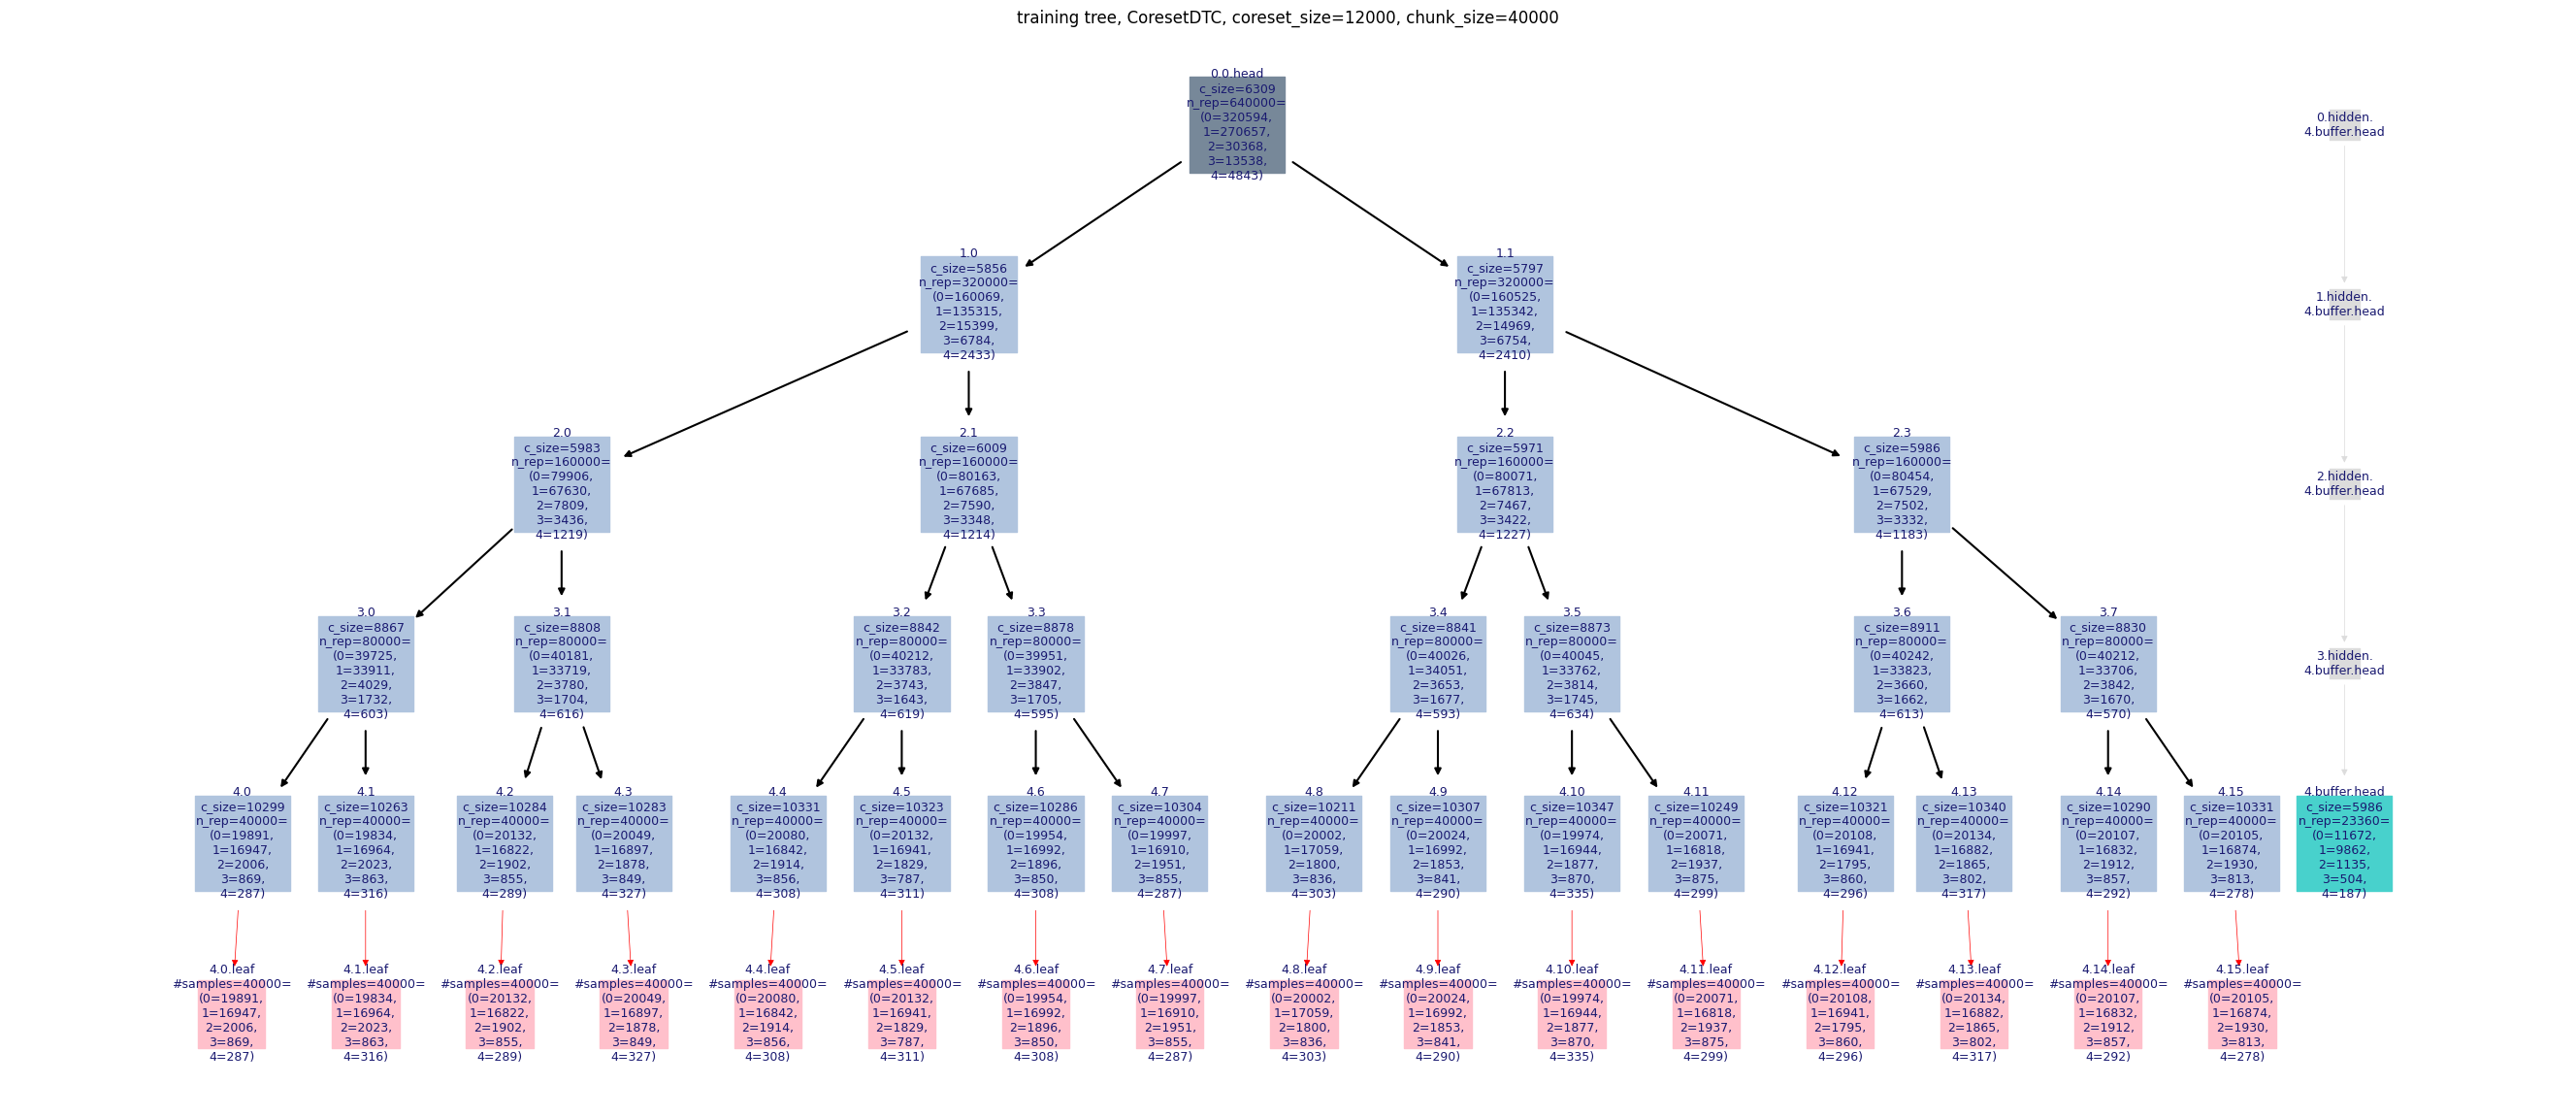

In [22]:
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)
service_obj.plot(output_dir)

### 6.4. Save coreset for future use

In [23]:
final_coreset_path = os.path.join(output_dir, "final_coreset")
service_obj.save_coreset(final_coreset_path)